### 1.1 Data Acquisition and Alignment

#### Import libraries

In [6]:
import importlib 
import os
import acquisition_alignment.dl_functions
import acquisition_alignment.connect_openeo
import acquisition_alignment.plt_functions

from acquisition_alignment.dl_functions import download_and_process_osm_data, download_sentinel2_images_openeo
from acquisition_alignment.connect_openeo import connect_to_openeo
from acquisition_alignment.plt_functions import plot_city_buildings, rgb_image, single_band_image, overlay_image, irb_image, stretch_contrast, get_epsg_from_tif, reproject_gdf

importlib.reload(acquisition_alignment.plt_functions)
importlib.reload(acquisition_alignment.dl_functions)
#importlib.reload(acquisition_alignment.connect_openeo)

<module 'acquisition_alignment.dl_functions' from 'c:\\Users\\PC\\Desktop\\TU\\AMLS\\acquisition_alignment\\dl_functions.py'>

#### Loop through 10 'big' cities and download OSM Data

In [5]:
pyrosm_path = f"acquisition_alignment/pyrosm_cities/"
# Ensure the directory exists
os.makedirs(pyrosm_path, exist_ok=True)

# List of 10 'big' cities
city_names = ["Tokyo", "New York City", "Bangkok", "Stockholm", "Sydney", "SanktPetersburg", "Moscow", "Muenchen", "Hannover", "Dublin"]
# city_names = ["Berlin"]

cities_data = {}

# Loop through each city
for city in city_names:
    # Download and process OSM data
    buildings_gdf, bbox = download_and_process_osm_data(city, pyrosm_path) # buildings_gdf crs=4326, [north, south, west, east]
    cities_data[city] = [buildings_gdf, bbox]
    print(f"Download, get building and boundaries of {city} done.\n")
    break


Tokyo data was downloaded to: c:\Users\PC\Desktop\TU\AMLS\acquisition_alignment\pyrosm_cities\Tokyo.osm.pbf
OSM data get_buildings done.
OSM for Tokyo converted into GeoDataFrame, with crs=EPSG:4326 done.
OSM data get_boundaries done.
Download, get building and boundaries of Tokyo done.



#### Connect to openeo.dataspace.copernicus

In [17]:
# Connect to OpenEO
connection = connect_to_openeo()

Connecting to OpenEO...
Authenticated using refresh token.
Connected to OpenEO.



#### Download Sentinel 2 L2a Data

In [ ]:
openeo_path = "acquisition_alignment/openeo_cities/Tokyo"
# Ensure the directory exists
os.makedirs(openeo_path, exist_ok=True)

# Download Sentinel-2 L2a images
dates_interval = ["2021-06-01T12:00:00Z", "2021-06-16T12:01:00Z"]
cloud_cover_percentage = 6

# Loop through each city and get Sentinel 2 L2a files
#for city in city_names:
#    # Call the download function
#    download_sentinel2_images_openeo(connection, bbox, start_date, end_date, cloud_cover_percentage, city)
_, bbox = cities_data["Tokyo"]
print(bbox)
download_sentinel2_images_openeo(connection, bbox, dates_interval, cloud_cover_percentage, "Tokyo", openeo_path)

#### Plot and Images

1 (a) Buildings from OpenStreetMaps.


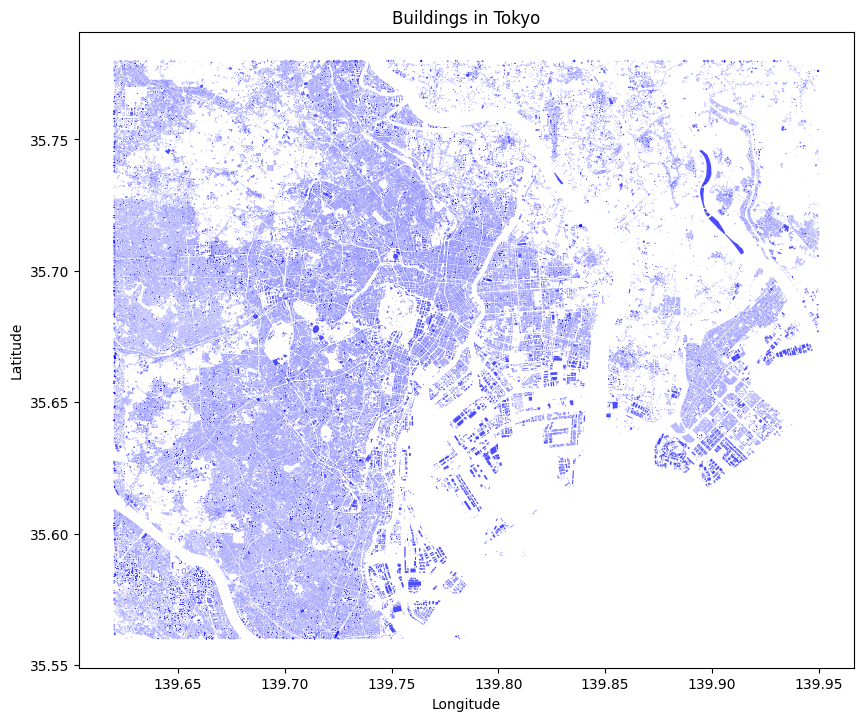

1 (b) RGB Bands from Sentinel 2.


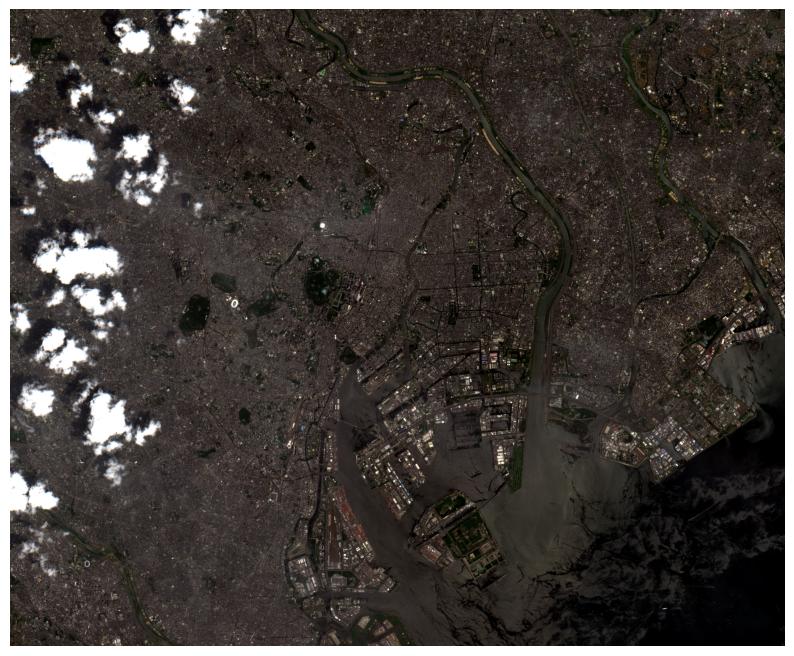

2 (a) Single Band.


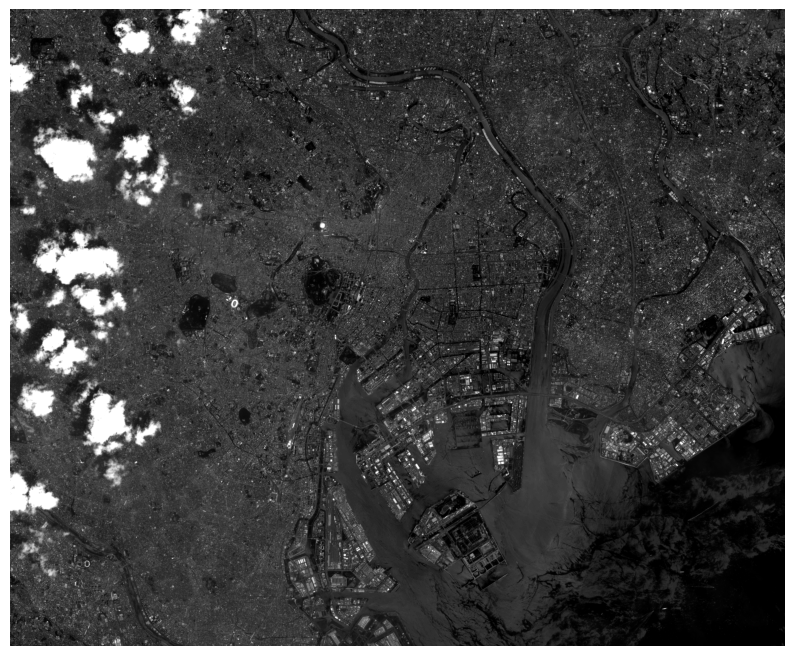

2 (b) Overlapping Buildings.


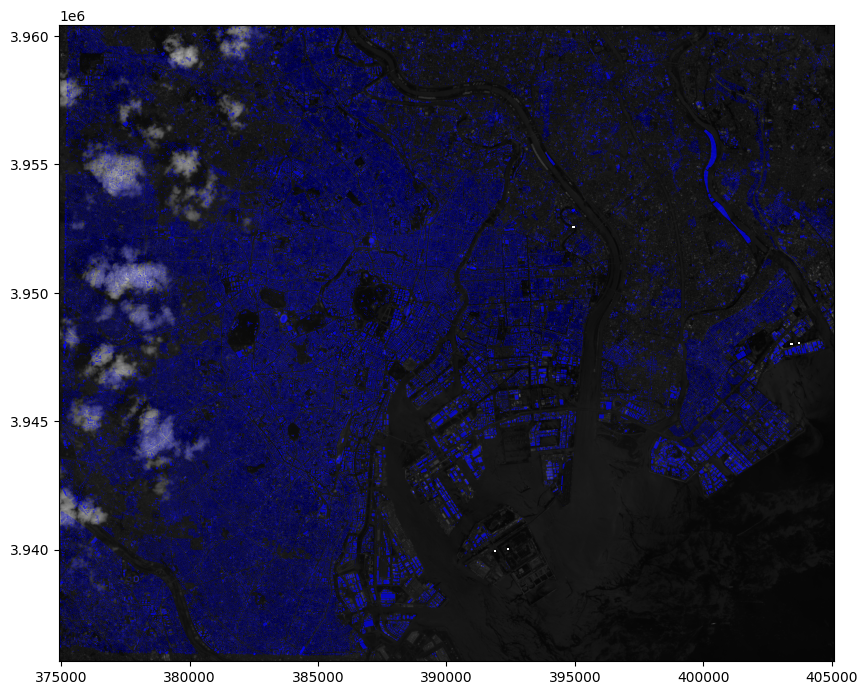

2 (c) IRB


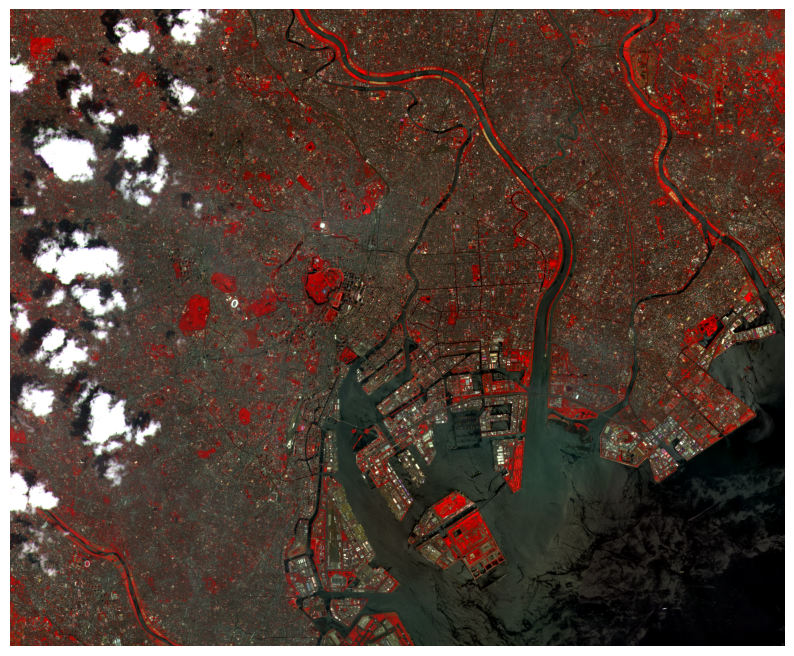

In [20]:
sentinel2_path = "acquisition_alignment/openeo_cities/Tokyo/openEO_2021-06-11Z.tif"  # Path to the Sentinel-2 L2a image of a city
band_index = 1  # For single band. Band index to read (1 for B04, 2 for B03, 3 for B02, 4 for B08) (cmap=gray anyway)

# Loop through each city in the dictionary and save image of the buildings of the city
for city, data in cities_data.items():
    buildings_gdf, bbox = data

    # Make directory for the images (for city). Ensure the directory exists
    images_save_dir = f"acquisition_alignment/images/{city}/"
    os.makedirs(images_save_dir, exist_ok=True)

    print("1 (a) Buildings from OpenStreetMaps.")
    plot_city_buildings(city, buildings_gdf, images_save_dir)

    print("1 (b) RGB Bands from Sentinel 2.")
    rgb_image(sentinel2_path, images_save_dir)

    print("2 (a) Single Band.")
    single_band_image(sentinel2_path, images_save_dir, band_index)

    print("2 (b) Overlap Buildings from OSM onto Sentinel-2 image.")
    overlay_image(buildings_gdf, sentinel2_path, images_save_dir, band_index)

    print("2 (c) IRB")
    irb_image(sentinel2_path, images_save_dir)
    
    break

### 1.2 Data Preparation (25/100 points)

In [82]:
import rasterio
from rasterio.features import geometry_mask
import numpy as np
import torch

def cloud_classifier(patch, threshold=0.4, cloud_fraction_limit=0.05):
    # Example: Use the mean of the blue band to classify clouds
    blue_band = patch[:, :, 2]
    cloud_fraction = np.mean(blue_band > threshold)
    
    return cloud_fraction < cloud_fraction_limit

# Create a binary mask of the buildings
def create_building_mask(buildings_gdf, transform, width, height):
    buildings_mask = geometry_mask(
        [geom for geom in buildings_gdf.geometry],
        transform=transform,
        invert=True,
        out_shape=(height, width)
    )
    return buildings_mask.astype(np.uint8)

def extract_patches(image, mask, patch_size):
    patches_image = []
    patches_mask = []
    # start: 0 -> patch_size, black margin on borders?....
    for i in range(0, image.shape[0] - patch_size + 1, patch_size):
        for j in range(0, image.shape[1] - patch_size + 1, patch_size):
            patch_img = image[i:i + patch_size, j:j + patch_size, :]
            patch_msk = mask[i:i + patch_size, j:j + patch_size]

            if cloud_classifier(patch_img):
                patches_image.append(patch_img)
                patches_mask.append(patch_msk)
        
    patches_image = np.stack(patches_image)
    patches_mask = np.stack(patches_mask)
    
    return patches_image, patches_mask

In [102]:
# Load the Sentinel-2 image
image_path = "acquisition_alignment/openeo_cities/Tokyo/openEO_2021-06-11Z.tif"
satellite_crs = get_epsg_from_tif(image_path)
buildings_gdf = reproject_gdf(buildings_gdf, satellite_crs)

# Patch extraction
patch_size = 128  # Example patch size

with rasterio.open(image_path) as src:
    transform = src.transform
    width = src.width
    height = src.height

    red = src.read(1) # * 0.0001 # B04
    green = src.read(2) # * 0.0001  # B03
    blue = src.read(3) # * 0.0001  # B02

    # Stretch the contrast of each band
    red_stretched = stretch_contrast(red)
    green_stretched = stretch_contrast(green)
    blue_stretched = stretch_contrast(blue)

    sentinel_image = np.dstack((red_stretched, green_stretched, blue_stretched)) # [H, W, C]

In [10]:
buildings_mask = create_building_mask(buildings_gdf, transform, width, height)

In [104]:
patches_image, patches_mask = extract_patches(sentinel_image, buildings_mask, patch_size)

# Convert to PyTorch tensors
tensor_image = torch.tensor(patches_image, dtype=torch.float32)
tensor_mask = torch.tensor(patches_mask, dtype=torch.long)  # Masks are typically long integers in PyTorch

# Ensure the dimensions are [N, H, W, C] for images and [N, H, W] for masks
tensor_image = tensor_image.permute(0, 1, 2, 3)
tensor_mask = tensor_mask.permute(0, 1, 2)

# Output
print("Image tensor shape:", tensor_image.shape)
print("Mask tensor shape:", tensor_mask.shape)

Image tensor shape: torch.Size([351, 128, 128, 3])
Mask tensor shape: torch.Size([351, 128, 128])


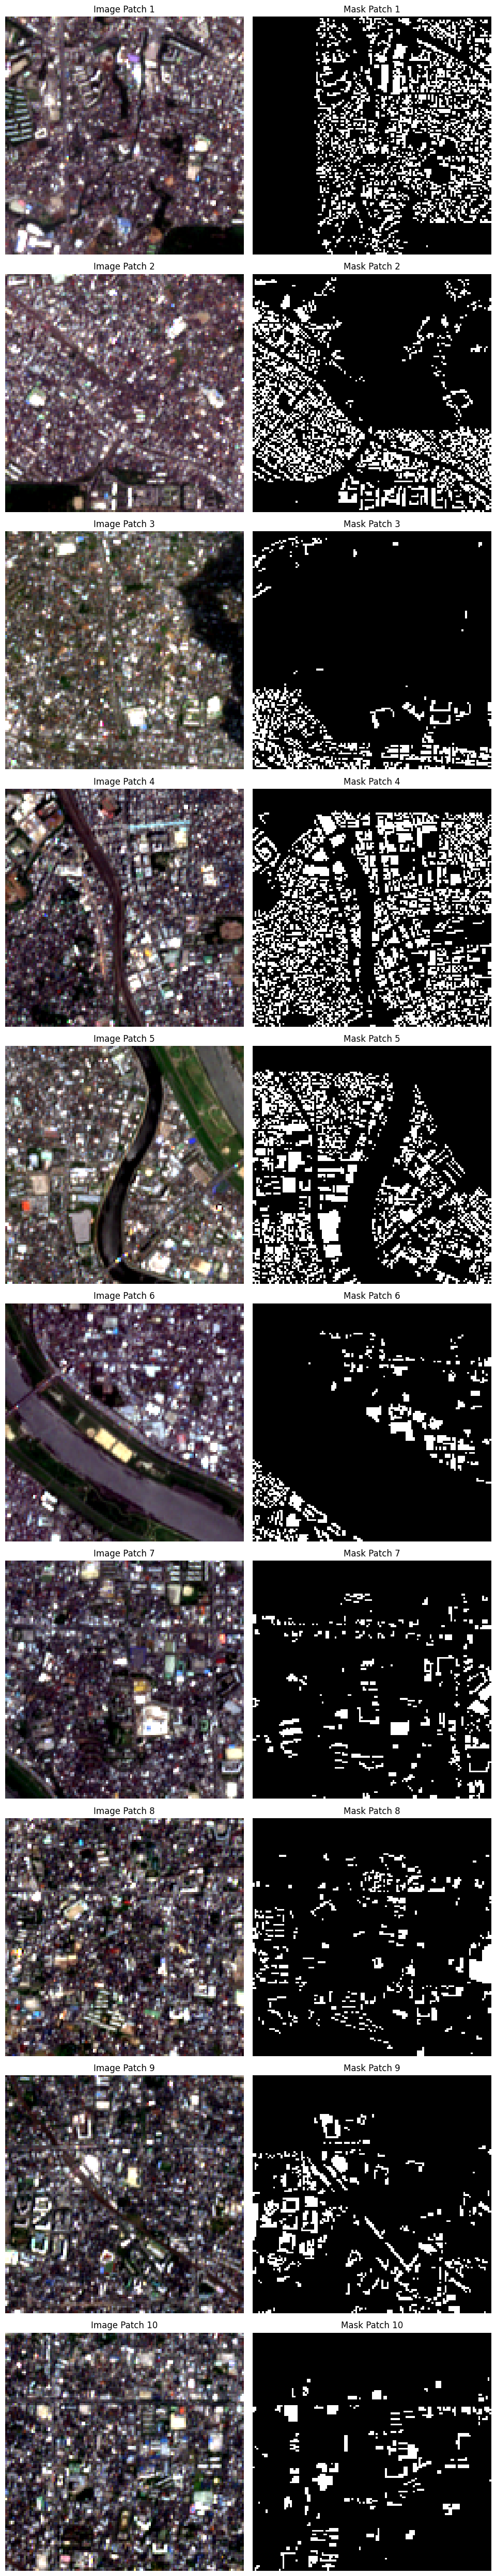

In [105]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_patches(tensor_image, tensor_mask, num_patches=10):
    fig, axs = plt.subplots(num_patches, 2, figsize=(10, num_patches * 5))
    for i in range(num_patches):
        # Convert the tensor image to numpy and move the channels to the last dimension
        img = tensor_image[i]
        
        # Stretch contrast for each channel (R, G, B, NIR)
        img_stretched = np.zeros_like(img)
        for c in range(img.shape[2]):
            img_stretched[:, :, c] = stretch_contrast(img[:, :, c])
        
        # Normalize the stretched image for visualization
        img_stretched = (img_stretched - np.min(img_stretched)) / (np.max(img_stretched) - np.min(img_stretched))
        
        # Display the image
        axs[i, 0].imshow(img_stretched[:, :, :3])  # Display only RGB channels

        axs[i, 0].set_title(f'Image Patch {i+1}')
        axs[i, 0].axis('off')
        
        # Display the mask
        axs[i, 1].imshow(tensor_mask[i].numpy(), cmap='gray')
        axs[i, 1].set_title(f'Mask Patch {i+1}')
        axs[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize the first 10 patches
visualize_patches(tensor_image, tensor_mask, num_patches=10)


In [114]:
import os
import numpy as np
from PIL import Image

def save_patches_and_masks(tensor_image, tensor_mask, output_dir, prefix='patch'):
    # Create directories if they don't exist
    image_dir = os.path.join(output_dir, 'all_images')
    mask_dir = os.path.join(output_dir, 'all_masks')
    os.makedirs(image_dir, exist_ok=True)
    os.makedirs(mask_dir, exist_ok=True)
    
    num_patches = tensor_image.shape[0]
    
    for i in range(num_patches):
        # Convert the tensor image and mask to numpy arrays
        img = tensor_image[i].numpy()
        mask = tensor_mask[i].numpy()
        
        # Save the image patch
        img_stretched = np.zeros_like(img)
        for c in range(img.shape[2]):
            img_stretched[:, :, c] = stretch_contrast(img[:, :, c])
        
        # Normalize the stretched image for saving
        img_stretched = (img_stretched - np.min(img_stretched)) / (np.max(img_stretched) - np.min(img_stretched)) * 255
        img_stretched = img_stretched.astype(np.uint8)
        
        # Convert to PIL image and save
        img_pil = Image.fromarray(img_stretched[:, :, :3])  # Save only RGB channels
        img_pil.save(os.path.join(image_dir, f'{prefix}_{i+1}_{city}.png'))
        
        # Save the mask
        mask_pil = Image.fromarray(mask.astype(np.uint8) * 255)  # Convert mask to binary image
        mask_pil.save(os.path.join(mask_dir, f'{prefix}_mask_{i+1}_{city}.png'))
        
    print(f'Saved {num_patches} image patches and masks to {output_dir}')

# Example usage
output_directory = 'preparation/data/'
save_patches_and_masks(tensor_image, tensor_mask, output_directory)


Saved 351 image patches and masks to preparation/data/


In [116]:
import os
import glob
import shutil
from sklearn.model_selection import train_test_split

# Function to pair image and mask files based on file naming convention
def pair_files(image_dir, mask_dir):
    image_files = glob.glob(os.path.join(image_dir, "*.png"))
    mask_files = glob.glob(os.path.join(mask_dir, "*.png"))
    
    paired_files = []
    for img_file in image_files:
        base_name = os.path.basename(img_file).replace("patch_", "").replace(".png", "")
        corresponding_mask = os.path.join(mask_dir, f"patch_mask_{base_name}.png")
        if corresponding_mask in mask_files:
            paired_files.append((img_file, corresponding_mask))
    
    return paired_files

image_dir = 'preparation/data/all_images'
mask_dir = 'preparation/data/all_masks'
paired_files = pair_files(image_dir, mask_dir)
print(len(paired_files))

351


In [117]:
def split_and_save(paired_files, output_dir, test_split=0.2, val_split=0.2, random_state=42):
    # Create output directories
    train_img_dir = os.path.join(output_dir, 'train/images')
    train_mask_dir = os.path.join(output_dir, 'train/masks')
    val_img_dir = os.path.join(output_dir, 'val/images')
    val_mask_dir = os.path.join(output_dir, 'val/masks')
    test_img_dir = os.path.join(output_dir, 'test/images')
    test_mask_dir = os.path.join(output_dir, 'test/masks')
    
    os.makedirs(train_img_dir, exist_ok=True)
    os.makedirs(train_mask_dir, exist_ok=True)
    os.makedirs(val_img_dir, exist_ok=True)
    os.makedirs(val_mask_dir, exist_ok=True)
    os.makedirs(test_img_dir, exist_ok=True)
    os.makedirs(test_mask_dir, exist_ok=True)
    
    # Split the data
    train_val_files, test_files = train_test_split(paired_files, test_size=test_split, random_state=random_state)
    train_files, val_files = train_test_split(train_val_files, test_size=val_split, random_state=random_state)
    
    # Function to copy files to respective directories
    def copy_files(file_pairs, img_dir, mask_dir):
        for img_file, mask_file in file_pairs:
            shutil.copy(img_file, img_dir)
            shutil.copy(mask_file, mask_dir)
    
    # Copy the files to respective directories
    copy_files(train_files, train_img_dir, train_mask_dir)
    copy_files(val_files, val_img_dir, val_mask_dir)
    copy_files(test_files, test_img_dir, test_mask_dir)
    
    print(f"Saved {len(train_files)} train, {len(val_files)} validation, and {len(test_files)} test file pairs.")

output_directory = 'preparation/data'
split_and_save(paired_files, output_directory)


Saved 224 train, 56 validation, and 71 test file pairs.


### 1.3 Modeling and Tuning (35/100 points)

### 1.4 Data Augmentation (25/100 points)